<h2>Useful Statistics Tasks</h2>
Two of the more useful consequences of the Central Limit Theorem are <b>confidence intervals</b> and <b>hypothesis testing</b>.  While the actual mechanism for Bayesian Statistics are quite different, the underlying principles are similar.  Let's start with the more intuitive extension of confidence intervals.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.style.use('ggplot')
import sys
sys.path.append("./src/")
from poisson import Bayes_Poisson

import numpy as np

<h3>Bayesian Credible Intervals</h3>
Using the Frequentist approach, when estimating a value for a parameter $\theta$, we choose a fixed point estimate that is the value coming from the central limit theorem.  We then leverage our understanding of the CLT to find $\theta_L, \theta_U$, the lower and upper limits based on the assumptions from the CLT.  Bayesians take a different approach.  Let's take a look at how a Bayesian might create a range of values for possible parameter values for say, a Poisson process. In <code>src/poisson.py</code>, I have a class for creating a Poisson model using Bayesian inference.  The conjugate prior to the Poisson is the Gamma distribution.  I'll show a derivation in an appendix if you're interest, but for now, just know that the update rule is that $\alpha_{posterior} = \alpha_{prior} + \sum_{i=1}^n x_i$ and $\beta_{posterior} = \beta_{prior} + n$, where $n$ is the number of periods of observation, and $x_i$ is the count of the number of events in period $i$.  We use $E[\lambda]=\frac{\alpha}{\beta}$ for further applications of the model.

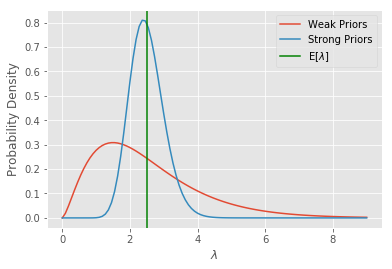

In [12]:
# Initialize two models both with lambda = 2.5, one with stronger priors
bp_weak, bp_strong = Bayes_Poisson(2.5), Bayes_Poisson(2.5, prior_strength=10.)
_x = np.linspace(0, 9, 100)
fig, ax = plt.subplots()
ax.plot(_x, bp_weak.prior_pdf(_x), label='Weak Priors')
ax.plot(_x, bp_strong.prior_pdf(_x), label='Strong Priors')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Probability Density')
ax.axvline(2.5, label=r'E[$\lambda$]', c='g')
_ = ax.legend(loc='upper right')

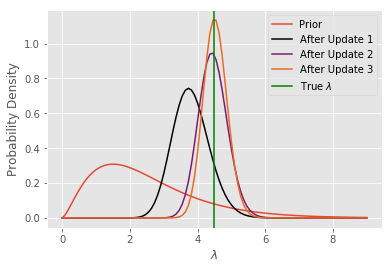

In [13]:
true_lambda = 4.5

# generate a series of Observations.
maxx_itt = 3
data = np.random.poisson(true_lambda, size=(maxx_itt,12))

# define color map
cmap = cm = plt.get_cmap('inferno') 
cNorm  = colors.Normalize(vmin=0, vmax=maxx_itt)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# Itteratively update our weakly initialized model
fig, ax = plt.subplots()
ax.plot(_x, bp_weak.prior_pdf(_x), label='Prior')
for i, obs in enumerate(data):
    bp_weak.update(obs)    
    ax.plot(_x, bp_weak.prior_pdf(_x), color=scalarMap.to_rgba(i), label='After Update {}'.format(i+1))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Probability Density')
ax.axvline(true_lambda, label=r"True $\lambda$", c='g')
_ = ax.legend(loc='upper right')

So far so good.  We have some true value of $\lambda$ that we don't know.  We use data to iteratively update our model, and we converge to the right parameter.  Here, we don't think that the distribution of lambda values is normally distributed.  Instead, we state that the values have a Poisson distribution.  Instead of quoting a 95% confidence interval, Bayesians tend to quote a <b>90% credible interval</b>.  It's really straight forward, we have a probability distribution for the parameter values (here, a $\Gamma$ distribution), and we find the points which maximally integrate to 90%.

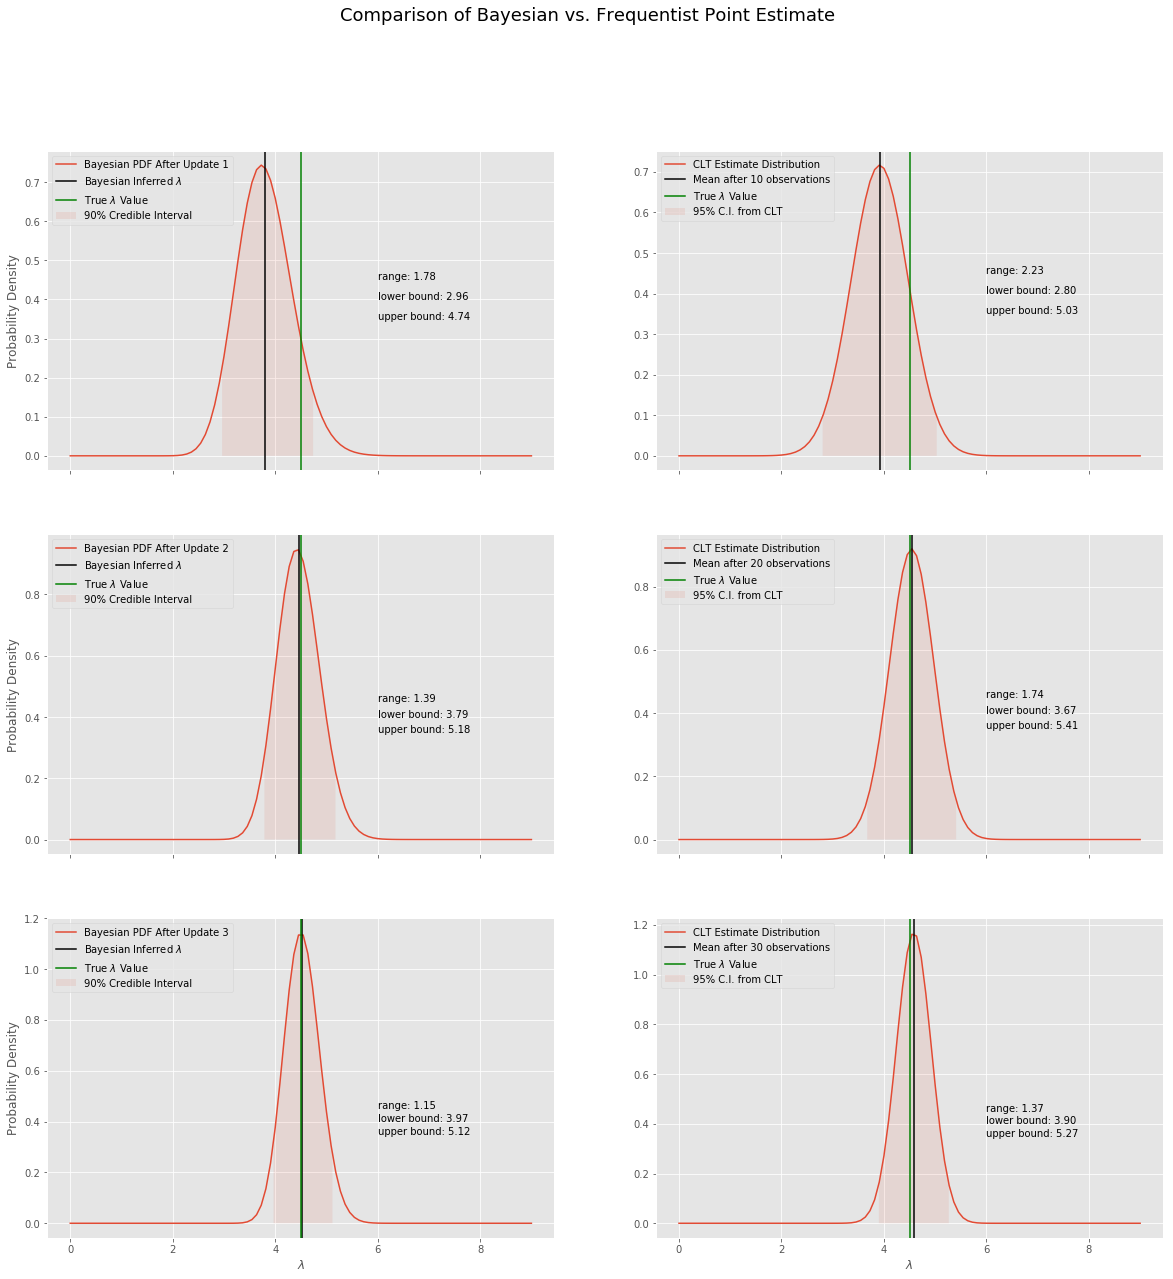

In [14]:
from scipy.stats import norm

d2 = np.concatenate((data[0], data[1]))
d3 = np.concatenate((d2, data[2]))
mu, sig = [np.mean(data[0])], [np.std(data[0], ddof=1)/np.sqrt(len(data[0]))]
mu.append(np.mean(d2)) 
sig.append(np.std(d2, ddof=1)/np.sqrt(len(d2)))
mu.append(np.mean(d3)) 
sig.append(np.std(d3, ddof=1)/np.sqrt(len(d3)))

fig, ax = plt.subplots(3,2, figsize=(20,20), sharex=True)
fig.suptitle('Comparison of Bayesian vs. Frequentist Point Estimate', fontsize=18)
for i in range(3):
    x_min, x_max = bp_weak.get_credible_region(step_n=i+1)
    _x_fill = np.linspace(x_min, x_max, 100)
    ax[i, 0].plot(_x, bp_weak.prior_pdf(_x, step_n=i+1), label='Bayesian PDF After Update {}'.format(i+1))
    ax[i, 0].axvline(bp_weak.get_lambda(step_n=i+1), label=r'Bayesian Inferred $\lambda$', c='k')
    ax[i, 0].axvline(true_lambda, label=r'True $\lambda$ Value', c='g')
    ax[i, 0].fill_between(_x_fill, bp_weak.prior_pdf(_x_fill, step_n=i+1), alpha=.1, label="90% Credible Interval")
    ax[i, 0].set_ylabel("Probability Density")
    ax[i, 0].text(6, .45, "range: {0:.2f}".format(x_max-x_min))
    ax[i, 0].text(6, .4, "lower bound: {0:.2f}".format(x_min))
    ax[i, 0].text(6, .35, "upper bound: {0:.2f}".format(x_max))
    ax[i, 0].legend(loc='upper left')
    
    x_min, x_max = mu[i]-2*sig[i], mu[i]+2*sig[i]
    _x_fill = np.linspace(x_min, x_max, 100)
    ax[i, 1].plot(_x, norm.pdf(_x, loc=mu[i], scale=sig[i]), label="CLT Estimate Distribution")
    ax[i, 1].fill_between(_x_fill, norm.pdf(_x_fill, loc=mu[i], scale=sig[i]), alpha=.1, label="95% C.I. from CLT")
    ax[i, 1].axvline(mu[i], c='k', label="Mean after {} observations".format(10*(i+1)))
    ax[i, 1].axvline(true_lambda, label=r'True $\lambda$ Value', c='g')
    ax[i, 1].text(6, .45, "range: {0:.2f}".format(x_max-x_min))
    ax[i, 1].text(6, .4, "lower bound: {0:.2f}".format(x_min))
    ax[i, 1].text(6, .35, "upper bound: {0:.2f}".format(x_max))
    ax[i, 1].legend(loc='upper left')

ax[2, 0].set_xlabel(r'$\lambda$')
_ = ax[2, 1].set_xlabel(r'$\lambda$')

<h3>Observations</h3>
<ul>
    <li>As the parameters for the gamma distribution get larger, it becomes visually difficult to distinguish between the two distributions.</li>
    <li>While we're comparing a 90% to 95% probability space, the Bayesian bands are consistently thinner, but still always contain the true value of $\lambda$.</li>
    <li>This was initialized with <b>weak</b> priors (equivalent to a single observation).  What is the expected behavior for the <b>strong</b> priors?</li>
</ul>

Use this cell and the same data from above to do updates to the strongly initialized model. Plot the updates, and see the rate of convergence.

<h2>Knowledge Transfer</h2>
In the above example, we get similar performance using the CLT and Bayesian techniques when we initialize with weak-incorrect priors.  What happens when we initialize with priors that are good?

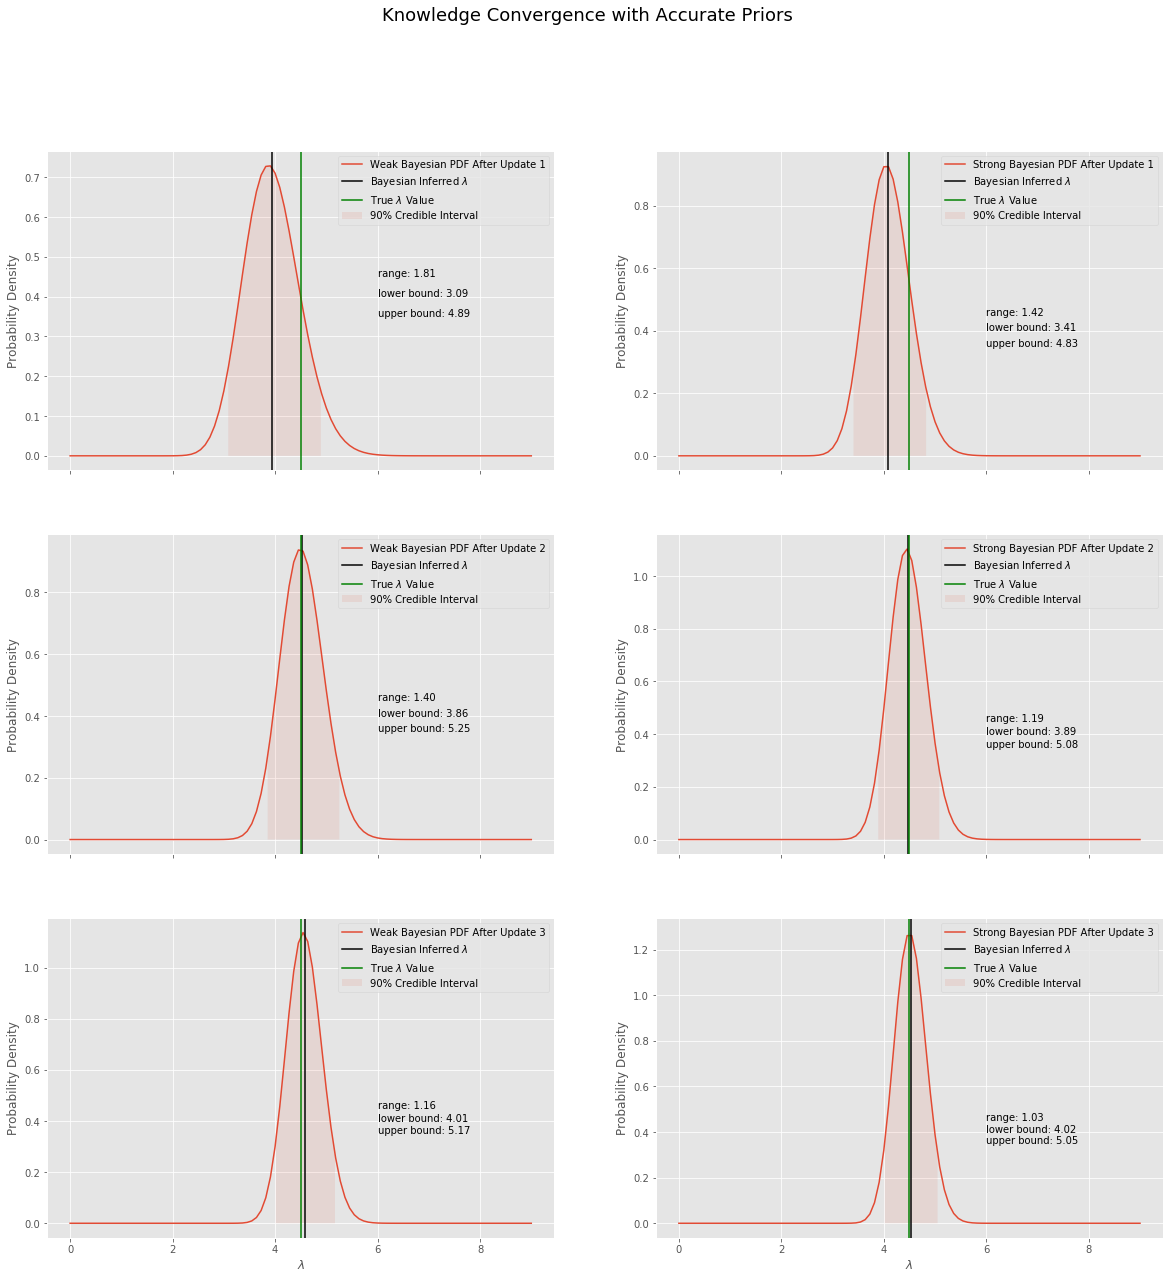

In [16]:
bp_weak_good, bp_strong_good = Bayes_Poisson(4.3), Bayes_Poisson(4.3, prior_strength=10.)
for obs in data:
    bp_weak_good.update(obs)
    bp_strong_good.update(obs)

fig, ax = plt.subplots(3,2, figsize=(20,20), sharex=True)
fig.suptitle('Knowledge Convergence with Accurate Priors', fontsize=18)
for i in range(3):
    x_min, x_max = bp_weak_good.get_credible_region(step_n=i+1)
    _x_fill = np.linspace(x_min, x_max, 100)
    ax[i, 0].plot(_x, bp_weak_good.prior_pdf(_x, step_n=i+1), label='Weak Bayesian PDF After Update {}'.format(i+1))
    ax[i, 0].axvline(bp_weak_good.get_lambda(step_n=i+1), label=r'Bayesian Inferred $\lambda$', c='k')
    ax[i, 0].axvline(true_lambda, label=r'True $\lambda$ Value', c='g')
    ax[i, 0].fill_between(_x_fill, bp_weak_good.prior_pdf(_x_fill, step_n=i+1), alpha=.1, label="90% Credible Interval")
    ax[i, 0].set_ylabel("Probability Density")
    ax[i, 0].text(6, .45, "range: {0:.2f}".format(x_max-x_min))
    ax[i, 0].text(6, .4, "lower bound: {0:.2f}".format(x_min))
    ax[i, 0].text(6, .35, "upper bound: {0:.2f}".format(x_max))
    ax[i, 0].legend(loc='upper right')
    
    
    x_min, x_max = bp_strong_good.get_credible_region(step_n=i+1)
    _x_fill = np.linspace(x_min, x_max, 100)
    ax[i, 1].plot(_x, bp_strong_good.prior_pdf(_x, step_n=i+1), label='Strong Bayesian PDF After Update {}'.format(i+1))
    ax[i, 1].axvline(bp_strong_good.get_lambda(step_n=i+1), label=r'Bayesian Inferred $\lambda$', c='k')
    ax[i, 1].axvline(true_lambda, label=r'True $\lambda$ Value', c='g')
    ax[i, 1].fill_between(_x_fill, bp_strong_good.prior_pdf(_x_fill, step_n=i+1), alpha=.1, label="90% Credible Interval")
    ax[i, 1].set_ylabel("Probability Density")
    ax[i, 1].text(6, .45, "range: {0:.2f}".format(x_max-x_min))
    ax[i, 1].text(6, .4, "lower bound: {0:.2f}".format(x_min))
    ax[i, 1].text(6, .35, "upper bound: {0:.2f}".format(x_max))
    ax[i, 1].legend(loc='upper right')
    
ax[2, 0].set_xlabel(r'$\lambda$')
_ = ax[2, 1].set_xlabel(r'$\lambda$')

If we compare to the credible intervals above, we can see we converge more quickly to the correct answer.  This is a huge motivational factor in using Bayesian statistics.  Bayesian approaches allow us to leverage experience from comparable situations where we might not have large sample sizes.  This is a huge advantage for these approaches.

<h2>Bayesian Hypothesis Testing</h2>
Bayesian Hypothesis Testing can be done in a few ways.  In practice, Bayesian statistics are leveraged a lot for 'practical' decisions, but I have seen less evidence of their use for ridged scientific studies.  To some degree, the roll of the prior makes this division seem natural and reasonable.  None the less, it is possible to do Bayesian testing in one of two ways:
<ol>
    <li>Choose the likelier of two opposing Hypothesis, ($H_0, H_a$)</li>
    <li>Run a likelihood Ratio test</li>
</ol>

<h3>Maximal Likelihood Selection</h3>
Let's continue to leverage our above example.  I can use the data to run a test with $H_0$ of $\lambda \le 4.0$, and of course $H_a$ is $\lambda$ > 4.0.  In this scenario, I simply leverage my posterior probability to examine what the integrated probability region looks like in both scenarios:

In [22]:
p_h0 = bp_weak.prior_cdf(4.0)
p_ha = 1 - p_h0
print("Probability of H_0: {0:.3f}\nProbability of H_a: {1:.3f}".format(p_h0, p_ha))
print("Accept H_a: ", p_ha > p_h0)

Probability of H_0: 0.291
Probability of H_a: 0.709
Accept H_a:  True


The Bayesian philosophy is to accept the more likely of the two hypothesis.  In this case $H_0$ is less likely than $H_a$.  This seems like a pretty reasonable conclusion.  What if instead, $H_0$ was 4.2?

In [28]:
p_h0 = bp_weak.prior_cdf(4.2)
p_ha = 1 - p_h0
print("Probability of H_0: {0:.3f}\nProbability of H_a: {1:.3f}".format(p_h0, p_ha))
print("Accept H_a: ", p_ha > p_h0)

Probability of H_0: 0.501
Probability of H_a: 0.499
Accept H_a:  False


While there is random chance with the data, for most rolls of the dice the to likelihoods are close.  We don't want the conclusion of a hypothesis test to be random chance.  A slightly more robust approach is a <b>likelihood ratio test</b>.  Here we 

In [29]:
print("Likelihood ratio: {0:.3f}".format(np.log10(p_ha/p_h0)))

# Let's look at that ratio when we test for a very low threshold
p_h0 = bp_weak.prior_cdf(3.8)
p_ha = 1 - p_h0
print("Likelihood ratio: {0:.3f}".format(np.log10(p_ha/p_h0)))

Likelihood ratio: -0.002
Likelihood ratio: 0.821


We can see that a log likelihood ratio is a bit more stable.  Negative values indicate negative evidence for the alternative hypothesis.  Values less than .5 are considered 'inconclusive' bodies of evidence.  There are differing standards from there, 1-2 being 'strong evidence', > 2 being 'decisive'.

<h2>Appendix - Poisson Conjugate Prior</h2>
We made the statement that the $\Gamma$ distribution is the conjugate prior of the Poisson distribution.  The $\Gamma$ distribution is defined here (note, that the $\Gamma$ distribution contains the $\Gamma$ function....because statisticians are dorks with no imagination):
$$
\Gamma(x, \alpha, \beta) = \frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}
$$

<code>scipy</code> defines the $\Gamma$ distribution using the only $x$ and $a$.  Here, $a=\alpha$.  The <code>scale</code> variable encodes the information about beta, with the relationship <code>scale</code>$=\frac{1}{\beta}$.  Let's look at a few combinations of the parameters:

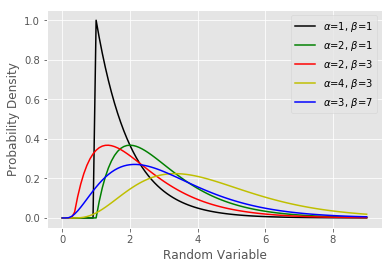

In [7]:
from scipy.stats import gamma
par_pairs = [(1, 1, 'k'), (2, 1, 'g'), (2, 3, 'r'), (4, 3, 'y'), (3, 7, 'b')]
fig, ax = plt.subplots()
for par in par_pairs:
    ax.plot(_x, gamma.pdf(_x, par[0], loc=1./par[1]), 
           color=par[2], label=r"$\alpha$={}, $\beta$={}".format(par[0], par[1]))
ax.set_xlabel("Random Variable")
ax.set_ylabel("Probability Density")
_ = ax.legend(loc="best")

That probably doesn't build much intuition, but it's useful to see that it's a continuous PDF defined for all of our possible values of $\lambda$.  It has the nice property that $E[x]=\frac{\alpha}{\beta}$.  So if we use this model for our .  If we use $\Gamma$ as $p(\lambda)$, let's look at what an update would look like:
$$
p(\lambda | x_1,...,x_n) = \frac{\mathcal{L}(x_1,...,x_n| \lambda)*p(\lambda, \alpha, \beta)}{p(x)}\\
= \frac{(\prod_{i=1}^n \frac{\lambda^{x_i}e^{-\lambda}}{x_i!})*(\frac{\beta^\alpha \lambda^{\alpha-1} e^{-\beta \lambda}}{\Gamma(\alpha)})}{\int_0^\infty \prod_{i=1}^n \frac{\lambda '^{x_i}e^{-\lambda '}}{x_i!}\frac{\beta^\alpha \lambda '^{\alpha-1} e^{-\beta \lambda'}}{\Gamma(\alpha)} \,d\lambda '}\\
= \frac{\lambda^{\sum x_i + \alpha-1} e^{-(\beta + n) \lambda}}{\int_0^\infty \lambda '^{\sum x_i + \alpha -1 }e^{-\lambda ' (\beta+n)} \,d\lambda '}\\
= \frac{\frac{(\beta+n)^{\alpha+\sum x_i}}{\Gamma(\alpha + \sum x_i)}}{\frac{(\beta+n)^{\alpha+\sum x_i}}{\Gamma(\alpha + \sum x_i)}}*\frac{\lambda^{\sum x_i + \alpha-1} e^{-(\beta + n) \lambda}}{\int_0^\infty \lambda '^{\sum x_i + \alpha -1 }e^{-\lambda ' (\beta+n)} \,d\lambda '}\\
=\frac{(\beta+n)^{\alpha+\sum x_i}}{\Gamma(\alpha + \sum x_i)}*\lambda^{\sum x_i + \alpha-1} e^{-(\beta + n) \lambda}\\
= \Gamma(\lambda, \alpha + \sum x_i, \beta + n)
$$